In [622]:
from time import time
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torch.utils.data as Data
import numpy as np
%matplotlib inline

# Load data
with open("data.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    

In [623]:
#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 101)
validation_size = int(len(X_train) * 0.1)
training_size = len(X_train) - validation_size
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size,random_state= 101)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

In [624]:
print('Training size:',X_train.shape[0])
print('Validation size:',X_validation.shape[0])
print('test size:',X_test.shape[0])

Training size: 1440
Validation size: 160
test size: 400


In [ ]:
#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [626]:
#Two help function
def one_hot(s):
    nb_digits=201
    batch_size = s.shape[0]
    seqlen = s.shape[1]
    s_onehot = torch.FloatTensor(batch_size,seqlen,nb_digits)
    s_onehot.zero_()
    s_onehot.scatter_(2, s.unsqueeze(2), 1)
    return s_onehot
def padding(data):
    left = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['left']))
        if diff>=1:
            data.iloc[i]['left']+= [0]*diff
        left.append((data.iloc[i]['left']))
    right = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['right']))
        if diff>=1:
            data.iloc[i]['right']+= [0]*diff
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)

In [627]:
#Padding and creat the loaders
X_train = padding(X_train)
Y_train = torch.FloatTensor(np.array(Y_train))
train_dataset  = Data.TensorDataset(X_train,Y_train)
train_loader = DataLoader(dataset, batch_size=32,shuffle=True)

X_validation = padding(X_validation)
Y_validation = torch.FloatTensor(np.array(Y_validation))
val_dataset  = Data.TensorDataset(X_validation,Y_validation)

X_test = padding(X_test)
Y_test = torch.FloatTensor(np.array(Y_test))
test_dataset  = Data.TensorDataset(X_test,Y_test)

In [628]:
class LSTMEncoder(nn.Module):
    """ Implements the network type integrated within the Siamese RNN architecture. """
    def __init__(self, opt, is_train=False):
        super(LSTMEncoder, self).__init__()
        self.node_size = opt['node_size']
        self.name = 'sim_encoder'
        self.hidden_size= opt['hidden_size']
        self.num_layers= opt['num_layers']
        self.embedding_dim = opt['embedding_dim']
        self.embedding_table = nn.Embedding(num_embeddings=self.node_size, embedding_dim=self.embedding_dim,
                                          padding_idx=0, max_norm=None, scale_grad_by_freq=False, sparse=False)
        self.lstm_rnn = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers)

    def initialize_hidden_plus_cell(self, batch_size):
        """ Re-initializes the hidden state, cell state, and the forget gate bias of the network. """
        zero_hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        zero_cell = torch.randn(self.num_layers, batch_size,self.hidden_size)
        return zero_hidden, zero_cell

    def forward(self, input_data, hidden, cell):
        """ Performs a forward pass through the network. """
        output = self.embedding_table(input_data)
        output, (hidden, cell) = self.lstm_rnn(output, (hidden, cell))
        return output[-1], hidden[-1], cell[-1]

In [651]:
class SiameseClassifier(nn.Module):
    """ Sentence similarity estimator implementing a siamese arcitecture. Uses pretrained word2vec embeddings. 
    Different to the paper, the weights are untied, to avoid exploding/ vanishing gradients. """
    def __init__(self, opt, is_train=False):
        super(SiameseClassifier, self).__init__()
        self.learning_rate= opt['learning_rate']
        # Initialize network
        self.encoder_a =  LSTMEncoder(opt, is_train)
        # Initialize network parameters
        self.initialize_parameters()
        # Declare loss function
        self.loss_function = nn.MSELoss()
        # Initialize network optimizers
        self.optimizer_a = optim.Adam(self.encoder_a.parameters(), lr=self.learning_rate,
                                      betas=(0.9, 0.999),weight_decay=0.5)

    def forward(self):
        """ Performs a single forward pass through the siamese architecture. """
        
        # Obtain the input length (each batch consists of padded sentences)
        input_length = self.batch_a.size(0)
        
        # Obtain sentence encodings from each encoder
        hidden_a, cell_a = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_a, hidden_a, cell_a = self.encoder_a(self.batch_a, hidden_a, cell_a)

        hidden_b, cell_b = self.encoder_a.initialize_hidden_plus_cell(self.batch_size)
        output_b, hidden_b, cell_b = self.encoder_a(self.batch_b, hidden_b, cell_b)

        # Format sentence encodings as 2D tensors
        self.encoding_a = output_a.squeeze()
        self.encoding_b = output_b.squeeze()

        # Obtain similarity score predictions by calculating the Manhattan distance between sentence encodings
        if self.batch_size == 1:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1))
        else:
            self.prediction = torch.exp(-torch.norm((self.encoding_a - self.encoding_b), 1, 1))
            

    def get_loss(self):
        """ Calculates the MSE loss between the network predictions and the ground truth. """
        # Loss is the L1 norm of the difference between the obtained sentence encodings
        self.loss = self.loss_function(self.prediction, self.labels)

    def load_pretrained_parameters(self,pretrained_state_dict_path):
        """ Loads the parameters learned during the pre-training on the SemEval data. """
        self.encoder_a.load_state_dict(torch.load(pretrained_state_dict_path))
        print('Pretrained parameters have been successfully loaded into the encoder networks.')
    
    def save_lstm(self,path):
        torch.save(self.encoder_a.state_dict(), path)

    def initialize_parameters(self):
        """ Initializes network parameters. """
        state_dict = self.encoder_a.state_dict()
        for key in state_dict.keys():
            if '.weight' in key:
                state_dict[key] = torch.nn.init.xavier_uniform_((state_dict[key]),gain=1)
            if '.bias' in key:
                bias_length = state_dict[key].size()[0]
                start, end = bias_length // 4, bias_length // 2
                state_dict[key][start:end].fill_(2.5)
        self.encoder_a.load_state_dict(state_dict)

    def train_step(self, train_batch_a, train_batch_b, train_labels):
        """ Optimizes the parameters of the active networks, i.e. performs a single training step. """
        # Get batches
        self.batch_a = train_batch_a.transpose(0,1)
        self.batch_b = train_batch_b.transpose(0,1)
        self.labels = train_labels
        self.batch_size = self.batch_a.size(1)
        self.encoder_a.zero_grad() 
        self.forward()
        self.get_loss()
        self.loss.backward()
        clip_grad_norm(self.encoder_a.parameters(), 0.25)
        self.optimizer_a.step()

    def test_step(self, test_batch_a, test_batch_b, test_labels):
        """ Performs a single test step. """
        self.batch_a = test_batch_a.transpose(0,1)
        self.batch_b = test_batch_b.transpose(0,1)
        self.labels = test_labels
        self.batch_size = self.batch_a.size(1)
        self.forward()
        self.get_loss()

In [652]:
num_epochs = 200
pretrain=False
opt = {
    'node_size':201,
    'hidden_size':50,
    'num_layers':1,
    'embedding_dim':100,
    'learning_rate':0.001
}

# Initialize global tracking variables
best_validation_accuracy = 0
epochs_without_improvement = 0
total_train_loss = list()
total_valid_loss = []
avg_trainings = []
avg_valids = []


# Loading model
if pretrain:
    classifier = torch.load('SiameseNN1.pt')
else:
    classifier = SiameseClassifier(opt, is_train=True)
    # Initialize parameters
    classifier.initialize_parameters()

    
for epoch in range(num_epochs):
    
    # Initiate the training data loader
    train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
    running_loss = list()
    # Training loop
    for i, (batch_x,label_var) in enumerate(train_loader):
        s1_var = batch_x[:,0,:]
        s2_var  = batch_x[:,1,:]
        #s1_var = one_hot(s1_var)
        #s2_var = one_hot(s2_var)
        classifier.train_step(s1_var, s2_var, label_var)
        train_batch_loss = classifier.loss.data[0]
        running_loss.append(train_batch_loss)
        total_train_loss.append(train_batch_loss)

        if i % 50 == 0 and i != 0:
            running_avg_loss = sum(running_loss) / len(running_loss)
            print('Epoch: %d | Training Batch: %d | Average loss: %.4f' %
                  (epoch, i , running_avg_loss))
            running_loss = []
            

    # Report epoch statistics
    avg_training_accuracy = sum(total_train_loss) / len(total_train_loss)
    print('Average training batch loss at epoch %d: %.4f' % (epoch, avg_training_accuracy))
    avg_trainings.append(avg_training_accuracy) 
    

    # Validate after each epoch; set tracking variables
    if epoch >= 0:
        # Initiate the training data loader
        valid_loader = DataLoader(val_dataset, batch_size=32,shuffle=True)
        
        # Validation loop (i.e. perform inference on the validation set)
        for i, (batch_x,label_var) in enumerate(valid_loader):
            s1_var = batch_x[:,0,:]
            s2_var  = batch_x[:,1,:]
            #s1_var = one_hot(s1_var)
            #s2_var = one_hot(s2_var)
            # Get predictions and update tracking values
            classifier.test_step(s1_var, s2_var, label_var)
            valid_batch_loss = classifier.loss.data[0]
            total_valid_loss.append(valid_batch_loss)

        # Report fold statistics
        avg_valid_accuracy = sum(total_valid_loss) / len(total_valid_loss)
        print('Average validation fold accuracy at epoch %d: %.4f' % (epoch, avg_valid_accuracy))
        avg_valids.append(avg_valid_accuracy)
        # Save network parameters if performance has improved
        if avg_valid_accuracy <= best_validation_accuracy:
            epochs_without_improvement += 1
        else:
            best_validation_accuracy = avg_valid_accuracy
            epochs_without_improvement = 0


/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average training batch loss at epoch 0: 0.5090
Average validation fold accuracy at epoch 0: 0.5312


/Users/richard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average training batch loss at epoch 1: 0.5090
Average validation fold accuracy at epoch 1: 0.5312
Average training batch loss at epoch 2: 0.5090
Average validation fold accuracy at epoch 2: 0.5312
Average training batch loss at epoch 3: 0.5090
Average validation fold accuracy at epoch 3: 0.5312
Average training batch loss at epoch 4: 0.5090
Average validation fold accuracy at epoch 4: 0.5312
Average training batch loss at epoch 5: 0.5090
Average validation fold accuracy at epoch 5: 0.5312
Average training batch loss at epoch 6: 0.5090
Average validation fold accuracy at epoch 6: 0.5312
Average training batch loss at epoch 7: 0.5090
Average validation fold accuracy at epoch 7: 0.5312
Average training batch loss at epoch 8: 0.5090
Average validation fold accuracy at epoch 8: 0.5312
Average training batch loss at epoch 9: 0.5090
Average validation fold accuracy at epoch 9: 0.5312
Average training batch loss at epoch 10: 0.5090
Average validation fold accuracy at epoch 10: 0.5312
Average 

Average validation fold accuracy at epoch 82: 0.4380
Average training batch loss at epoch 83: 0.4429
Average validation fold accuracy at epoch 83: 0.4384
Average training batch loss at epoch 84: 0.4434
Average validation fold accuracy at epoch 84: 0.4387
Average training batch loss at epoch 85: 0.4440
Average validation fold accuracy at epoch 85: 0.4391
Average training batch loss at epoch 86: 0.4445
Average validation fold accuracy at epoch 86: 0.4394
Average training batch loss at epoch 87: 0.4450
Average validation fold accuracy at epoch 87: 0.4398
Average training batch loss at epoch 88: 0.4456
Average validation fold accuracy at epoch 88: 0.4401
Average training batch loss at epoch 89: 0.4461
Average validation fold accuracy at epoch 89: 0.4404
Average training batch loss at epoch 90: 0.4466
Average validation fold accuracy at epoch 90: 0.4407
Average training batch loss at epoch 91: 0.4470
Average validation fold accuracy at epoch 91: 0.4410
Average training batch loss at epoch 9

Average validation fold accuracy at epoch 162: 0.4531
Average training batch loss at epoch 163: 0.4663
Average validation fold accuracy at epoch 163: 0.4532
Average training batch loss at epoch 164: 0.4665
Average validation fold accuracy at epoch 164: 0.4533
Average training batch loss at epoch 165: 0.4666
Average validation fold accuracy at epoch 165: 0.4534
Average training batch loss at epoch 166: 0.4668
Average validation fold accuracy at epoch 166: 0.4535
Average training batch loss at epoch 167: 0.4669
Average validation fold accuracy at epoch 167: 0.4536
Average training batch loss at epoch 168: 0.4671
Average validation fold accuracy at epoch 168: 0.4537
Average training batch loss at epoch 169: 0.4672
Average validation fold accuracy at epoch 169: 0.4537
Average training batch loss at epoch 170: 0.4673
Average validation fold accuracy at epoch 170: 0.4538
Average training batch loss at epoch 171: 0.4675
Average validation fold accuracy at epoch 171: 0.4539
Average training ba

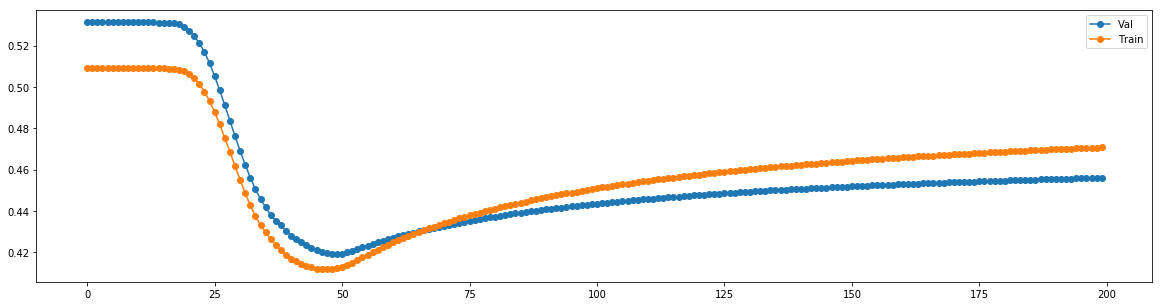

In [653]:
fig, ax = plt.subplots(figsize= (20,5))
ax.plot(avg_valids,marker='o',label='Val')
ax.plot(avg_trainings,marker='o',label='Train')
ax.legend()

In [650]:
torch.save(classifier, 'SiameseNN1.pt')

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/richard/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTMEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
